In [ ]:
!nvidia-smi

Mon Apr  5 18:30:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.4.1


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
!pip install -Uqr models/official/requirements.txt

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.4.1
Eager mode:  True
Hub version:  0.11.0
GPU is available


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
train_ds = pd.read_csv("/content/drive/My Drive/NLP/Raw_data/Train.csv",nrows = 20000)
valid_ds = pd.read_csv("/content/drive/My Drive/NLP/Raw_data/Valid.csv",nrows = 4000)
test_ds = pd.read_csv("/content/drive/My Drive/NLP/Raw_data/Test.csv",nrows = 2000)
train_ds.shape,valid_ds.shape,test_ds.shape

((20000, 2), (4000, 2), (2000, 2))

In [ ]:
train_ds.tail(10)

,text,label
19990,"First of all, let me say that I am in no way d...",0
19991,"What else can you say about this movie,except ...",0
19992,'The English Patient' is a love story set in E...,1
19993,"""Death Lends A Hand"" is one of the pivotal ear...",1
19994,This movie is stuffed full of stock Horror mov...,1
19995,"I was required to watch the movie for my work,...",0
19996,"""White Noise"" had potential to be one of the m...",0
19997,The Five Deadly Venoms is a great kung-fu acti...,1
19998,Ali G Indahouse has got to be one of the funni...,1
19999,I found myself at sixes and sevens while watch...,1


<AxesSubplot:title={'center':'Target distribution'}, ylabel='Frequency'>

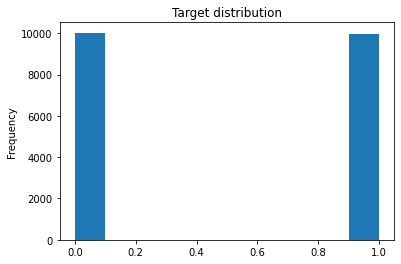

In [ ]:
train_ds.label.plot(kind='hist',title='Target distribution')

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_ds['text'].values, train_ds['label'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_ds.text.values, valid_ds.label.values))

  for text,label in train_data.take(1):
    print(text)
    print(label)
  

tf.Tensor(b'I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
label_list = [0, 1] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",trainable =True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file,do_lower_case)

In [ ]:
tokenizer.wordpiece_tokenizer.tokenize('hi,how are you doing?')

['hi', '##,', '##how', 'are', 'you', 'doing', '##?']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi,how are you doing?'))

[7632, 29623, 14406, 2024, 2017, 2725, 29632]

In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example  = classifier_data_lib.InputExample(guid=None,
                                              text_a = text.numpy(),
                                              text_b = None,
                                              label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
  return (feature.input_ids,feature.input_mask,feature.segment_ids,feature.label_id)

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text,label],
                                                                Tout = [tf.int32,tf.int32,tf.int32,tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
       'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
  }
  
  return (x,label_id)

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32,drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32,drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  drop = tf.keras.layers.Dropout(0.7)(pooled_output)
  output = tf.keras.layers.Dense(1,activation='sigmoid',name='output')(drop)

  model = tf.keras.Model(
      inputs={
        'input_word_ids': input_word_ids,
       'input_mask': input_mask,
       'input_type_ids': input_type_ids
      },
      outputs=output
  )
  return model

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

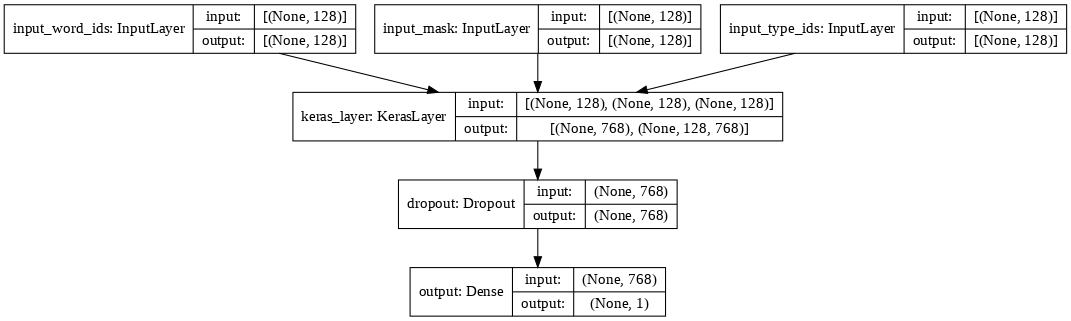

In [ ]:
tf.keras.utils.plot_model(model=model,show_shapes=True,dpi=76)

In [ ]:
# Train model
epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs = epochs,
                    verbose=1)

Epoch 1/4
625/625 [==============================] - 575s 892ms/step - loss: 0.4908 - binary_accuracy: 0.7535 - val_loss: 0.2893 - val_binary_accuracy: 0.8735
Epoch 2/4
625/625 [==============================] - 572s 907ms/step - loss: 0.2494 - binary_accuracy: 0.8972 - val_loss: 0.3183 - val_binary_accuracy: 0.8813
Epoch 3/4
625/625 [==============================] - 573s 909ms/step - loss: 0.1557 - binary_accuracy: 0.9390 - val_loss: 0.4150 - val_binary_accuracy: 0.8770
Epoch 4/4
625/625 [==============================] - 572s 908ms/step - loss: 0.0821 - binary_accuracy: 0.9715 - val_loss: 0.4861 - val_binary_accuracy: 0.8802


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

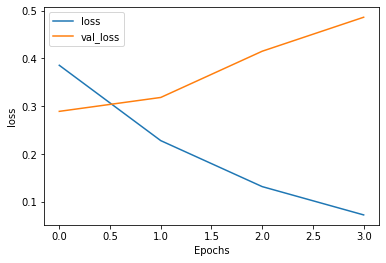

In [ ]:
plot_graphs(history,'loss')

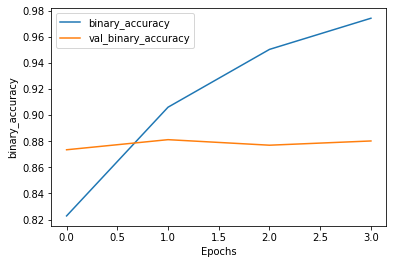

In [ ]:
plot_graphs(history,'binary_accuracy')

In [ ]:
sample_example = ["i like you ","i hate apples","the weather is nice"]
test_data = tf.data.Dataset.from_tensor_slices((sample_example,[0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold =0.5 # between 0 and 1
['Positive' if pred>=threshold else 'Negative' for pred in preds]

['Positive', 'Negative', 'Positive']

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((test_ds['text'].values, test_ds['label'].values))
test_data = (test_data.map(to_feature_map).batch(10))

In [ ]:
prds = model.predict(test_data)

In [ ]:
prds.shape

(2000, 1)

In [ ]:
prds[0:5]

array([[1.3061242e-01],
       [2.6320128e-02],
       [2.6388490e-03],
       [9.9962938e-01],
       [7.3970971e-04]], dtype=float32)

In [ ]:
test_ds.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [ ]:
threshold_test = 0.5
result = [1 if pred>=threshold else 0 for pred in prds]

In [ ]:
real_label = test_ds.label.values

In [ ]:
real_label.dtype

dtype('int64')

In [ ]:
pre_label = np.array(result)

In [ ]:
pre_label.dtype

dtype('int64')

In [ ]:
real_label.shape,pre_label.shape

((2000,), (2000,))

In [ ]:
y = real_label == pre_label

In [ ]:
y[0:5]

array([ True,  True,  True,  True,  True])

In [ ]:
print('True number :', np.sum(y!=0))
print('False number :', np.sum(y==0))

True number : 1744
False number : 256


In [ ]:
print('The accuracy on the test data:',np.sum(y!=0)/2000 )

The accuracy on the test data: 0.872


In [ ]:
sample_example = ["I fell lost"]
test_data = tf.data.Dataset.from_tensor_slices((sample_example,[0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold =0.5 # between 0 and 1
['Positive' if pred>=threshold else 'Negative' for pred in preds]

['Negative']